In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib as mlab
import matplotlib.pyplot as plt
import xarray as xr
import os as os
import matplotlib.gridspec as gridspec

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from Plot_tools import *

from scipy.ndimage import label, generate_binary_structure, binary_dilation

# define a grid to interpolation profiles to

zhgts = 250. + 250.*np.arange(60)

_nthreads = 2

#---------------------------------------------------------------------
def interp3dz_np(data, z3d, z1d, nthreads = _nthreads):
    
    dinterp = np.zeros((len(z1d),data.shape[1]),dtype=np.float32)

    if nthreads < 0:  # turning this off for now.
        def worker(j):
            print("running %d %s" % (i, data.shape))
            dinterp[:,j] = np.interp(z1d, z3d[:,j], data[:,j])

        pool = mp.Pool(nthreads)
        for i in np.arange(data.shape[2]):
            pool.apply_async(worker, args = (i, ))
        pool.close()
        pool.join()
        
        return dinterp
    
    else:        
        for j in np.arange(data.shape[1]):
            dinterp[:,j] = np.interp(z1d, z3d[:,j], data[:,j])

        return dinterp



In [68]:
def generate_ideal_profiles(run_dir, model_type='wrf', w_thresh = 5.0, cref_thresh = 45., min_pix=5):
    
    print(w_thresh, cref_thresh, min_pix)
    
    if model_type == 'wrf':
        
        def open_mfdataset_list(data_dir, pattern):
            """
            Use xarray.open_mfdataset to read multiple netcdf files from a list.
            """
            filelist = os.path.join(data_dir,pattern)
            return xr.open_mfdataset(filelist, combine='nested', concat_dim=['Time'], parallel=True)
    
        ds   = open_mfdataset_list(run_dir,  "wrfout*")

        w    = ds.W.values
        w    = 0.5*(w[:,1:,:,:] + w[:,:-1,:,:])

        dbz  = ds.REFL_10CM.values
        pres = ds.P.values
        z    = ds.PHB.values/9.806
        z    = 0.5*(z[:,1:,:,:] + z[:,:-1,:,:])

        profiles = compute_obj_profiles(w, dbz, pres, z, w_thresh = w_thresh, cref_thresh = cref_thresh, min_pix=min_pix)
        
        ds.close()

        return profiles
    
    if model_type == 'fv3':
        
        def open_mfdataset_list(data_dir, pattern):
            """
            Use xarray.open_mfdataset to read multiple netcdf files from a list.
            """
            filelist = os.path.join(data_dir,pattern)
            return xr.open_mfdataset(filelist, combine='nested', concat_dim=['time'], parallel=True)
    
        ds   = open_mfdataset_list(run_dir,   "*.nc")

        w    = ds.W.values
        w    = 0.5*(w[:,1:,:,:] + w[:,:-1,:,:])
        dbz  = ds.REFL_10CM.values
        pres = ds.P.values
        z    = ds.PHB.values/9.806
        z    = 0.5*(z[:,1:,:,:] + z[:,:-1,:,:])

        profiles = compute_obj_profiles(w, dbz, pres, z, w_thresh = w_thresh, cref_thresh = cref_thresh, min_pix=min_pix)
        
        ds.close()

        return profiles
    
    if model_type == 'cm1':
        
        def open_mfdataset_list(data_dir, pattern):
            """
            Use xarray.open_mfdataset to read multiple netcdf files from a list.
            """
            filelist = os.path.join(data_dir,pattern)
            return xr.open_mfdataset(filelist, parallel=True)
    
        ds = open_mfdataset_list(run_dir,  "cm1out_0000*.nc")

        w    = ds.winterp.values
        dbz  = ds.dbz.values
        pres = ds.prs.values
        z    = ds.zh.values * 1000. # heights are in km
        z3d  = np.broadcast_to(z[np.newaxis, :, np.newaxis, np.newaxis], w.shape)

        profiles = compute_obj_profiles(w, dbz, pres, z3d, w_thresh = w_thresh, cref_thresh = cref_thresh, min_pix=min_pix)
        
        ds.close()

        return profiles

#-------------------------------------------------------------------------------
def compute_obj_profiles(W, DBZ, PRES, Z, w_thresh = 5.0, cref_thresh = 45., min_pix=5):
           
    cref = DBZ.max(axis=1)
        
    mask_cref = np.where(cref >= cref_thresh, 1, 0)
    
    mask_p = np.where(PRES <= 70000., 1, 0)
    
    mask_w = np.where(W > w_thresh, 1, 0)
    
    mask_w_p = np.where( mask_p + mask_w == 2, 1, 0)
    
    mask_w_p_2d = np.where(mask_w_p.max(axis=1) + mask_cref == 2, 1, 0)

    f_mask = np.array(np.where(mask_w_p_2d == 1, 1, 0), dtype=np.int8)
        
    # this next block of code looks for a 3x3 connected region of True (1) values.
    
    connectivity = np.ones((3,) * 2)  # 3x3 matric of ones

    wlist   = [] 
    all_obj = 0
    w_obj   = 0
    
    for n in np.arange(W.shape[0]): # loop over number of time steps.
        
        # check to see if there are objects
        
        if (np.sum(f_mask[n]) == 0):
            
            continue

        else:
        
            labeled_array = label(f_mask[n], connectivity)[0]        # returns a 2D array of labels for updrafts)

            num_obj = np.unique(labeled_array)                       # find the number of unique objects (background will be one obj)

            all_obj += (num_obj.shape[0]-1)

            if( num_obj.shape[0] > 1 ):                              # if there is more than the background object, process array.

                for l in num_obj[1:]:                                # this is just a list of 1,2,3,4.....23,24,25....
                    npix = np.sum(labeled_array == l)                # this is a size check - number of pixels assocated with a label
                    if npix >= min_pix:
                        jloc, iloc = np.where(labeled_array == l)    # extract out the locations of the updrafts 
                        w_obj += 1
                        if len(iloc) > 0:
                            wraw    = W[n,:,jloc,iloc]               # get w_raw profiles
                            zraw    = Z[n,:,jloc,iloc]               # get z_raw profiles

                            profile = interp3dz_np(wraw.transpose(), zraw.transpose(), zhgts, nthreads = _nthreads)

                            wlist.append([profile.mean(axis=1)],)
                            
    if( len(wlist) < 1 ):
        
        print("\n ---> Compute_Obj_Profiles found no objects...returning zero...\n")
        return np.zeros((zhgts.shape[0],1))
    
    else:
        
        wprofile = np.squeeze(np.asarray(wlist), axis=1).transpose()

        print("\n Number of selected updraft profiles:  %d \n Number of labeled objects:  %d\n" % (w_obj, all_obj))
    
        return np.sort(wprofile, axis=1)

In [71]:
w_thresh = 5.0
cref_thresh = 45.
min_pix = 3

# CM1

input_dir  = '/scratch/wicker/cm1r20.3/run'
output_dir = './'

cm1_q14 = generate_ideal_profiles(str(os.path.join(input_dir, 'squall_q14_s12')), model_type='cm1', w_thresh = w_thresh, cref_thresh = cref_thresh, min_pix=min_pix)
# cm1_q11 = generate_model_profiles(str(os.path.join(input_dir, 'squall_q11_s12')), model_type='cm1', w_thresh = w_thresh, cref_thresh = cref_thresh, min_pix=min_pix)
# cm1_q12 = generate_model_profiles(str(os.path.join(input_dir, 'squall_q12_s12')), model_type='cm1', w_thresh = w_thresh, cref_thresh = cref_thresh, min_pix=min_pix)
# cm1_q13 = generate_model_profiles(str(os.path.join(input_dir, 'squall_q13_s12')), model_type='cm1', w_thresh = w_thresh, cref_thresh = cref_thresh, min_pix=min_pix)
# cm1_q15 = generate_model_profiles(str(os.path.join(input_dir, 'squall_q15_s12')), model_type='cm1', w_thresh = w_thresh, cref_thresh = cref_thresh, min_pix=min_pix)
# cm1_q16 = generate_model_profiles(str(os.path.join(input_dir, 'squall_q16_s12')), model_type='cm1', w_thresh = w_thresh, cref_thresh = cref_thresh, min_pix=min_pix)

# WRF ######

in_dir  = "/scratch/larissa.reames/ideal_updrafts"
out_dir = "/work/wicker/CAM_analysis_tools"
shear   = "shallow_12.5"

wrf3_dir      = str(os.path.join(in_dir, "WRF_km4_dt15", shear))
wrf3_wprofile = generate_ideal_profiles(str(os.path.join(wrf3_dir)), model_type='wrf', w_thresh = w_thresh, cref_thresh = cref_thresh, min_pix=min_pix)


# FV3 #######
in_dir  = "/scratch/larissa.reames/ideal_updrafts"
out_dir = "/work/wicker/CAM_analysis_tools"
shear   = "shallow_12.5"

fv3A_dir     = str(os.path.join(in_dir, "FV3_dt20_hord6_q14", shear))
fv3_wprofile = generate_ideal_profiles(str(os.path.join(fv3A_dir)), model_type='fv3', w_thresh = w_thresh, cref_thresh = cref_thresh, min_pix=min_pix)


5.0 45.0 3

 Number of selected updraft profiles:  212 
 Number of labeled objects:  263

0 4.204102
1 4.302211
2 4.8133845
3 4.8247313
4 4.9614806
5 5.0847745
6 5.475086
7 5.6139283
8 5.6594543
9 5.752098
10 5.820054
11 5.8217206
12 5.9281473
13 5.9701505
14 6.064587
15 6.151975
16 6.2402143
17 6.305063
18 6.3242574
19 6.361599
20 6.4492903
21 6.572529
22 6.588188
23 6.6226945
24 6.629449
25 6.788199
26 6.832574
27 6.8520355
28 6.8764715
29 6.90679
30 6.9466352
31 6.965956
32 6.982077
33 7.005061
34 7.021703
35 7.0256376
36 7.0668836
37 7.10068
38 7.1361575
39 7.150817
40 7.1793118
41 7.213615
42 7.2274723
43 7.2496166
44 7.2862396
45 7.3045545
46 7.3256526
47 7.337001
48 7.3704176
49 7.3902946
50 7.4480743
51 7.481486
52 7.503801
53 7.5336533
54 7.5754
55 7.654335
56 7.6719556
57 7.6925406
58 7.704924
59 7.7211123
60 7.741797
61 7.767298
62 7.7872314
63 7.824697
64 7.840586
65 7.8612704
66 7.8779316
67 7.9004507
68 7.919443
69 7.940319
70 7.968742
71 7.999712
72 8.016328
73 8.016778


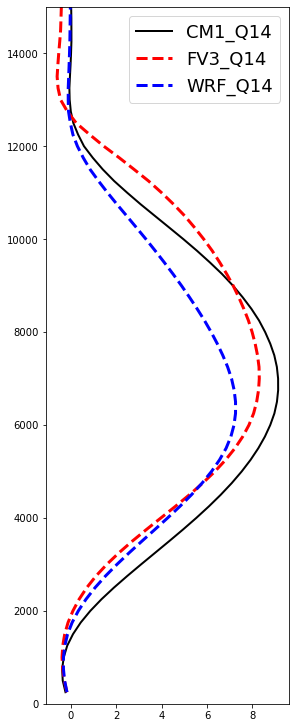

In [72]:
fig, ax = plt.subplots(1,1, constrained_layout=True,figsize=(4,10))

ax.plot(cm1_q14.mean(axis=1), zhgts, color='k', linewidth=2., label='CM1_Q14')

ax.plot(fv3_wprofile.mean(axis=1), zhgts, color='r', linewidth=3., linestyle='--', label='FV3_Q14')
ax.plot(wrf3_wprofile.mean(axis=1), zhgts, color='b', linewidth=3., linestyle='--', label='WRF_Q14')
ax.set_ylim(0.0,15000.)
ax.legend(fontsize=18)
plt.show()